# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [2]:
LV_NAME = "LV101"

In [3]:
LV_AXIS_THRESHOLD = None  # 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [4]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/manuscript/content/images/lvs_analysis/lv101')

In [5]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/opt/manuscript/content/images/lvs_analysis/lv101/lv101-cell_types.svg')

# Load MultiPLIER summary

In [6]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [7]:
multiplier_model_summary.shape

(2157, 5)

In [8]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [9]:
# INPUT_SUBSET = "z_score_std"

In [10]:
# INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [11]:
# input_filepath = Path(
#     conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
#     INPUT_SUBSET,
#     f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
# ).resolve()
# display(input_filepath)

# assert input_filepath.exists(), "Input file does not exist"

# input_filepath_stem = input_filepath.stem
# display(input_filepath_stem)

In [12]:
# data = pd.read_pickle(input_filepath)

In [13]:
# data.shape

In [14]:
# data.head()

## LV data

In [15]:
# lv_obj = LVAnalysis(LV_NAME, data)
lv_obj = LVAnalysis(LV_NAME)

In [16]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

,pathway,LV index,AUC,p-value,FDR
438,IRIS_NKcell-IL2stimulated,101,0.768951,0.002283,0.014788
439,DMAP_NKA3,101,0.824968,0.000049,0.000597
441,SVM NK cells activated,101,0.815507,0.000003,0.000045


In [17]:
lv_data = lv_obj.get_experiments_data()

SRP060416, SRP033466, SRP063840, SRP059057, SRP043339, SRP061881, SRP055569, SRP045500, SRP007461, SRP051688, SRP064464, 

/opt/code/libs/data/recount2.py:360: UserWarning: Not all experiments data could be loaded (10 != 11)
  warnings.warn(


In [18]:
lv_data.shape

(1843, 39)

In [19]:
lv_data.head()

tonsil donor facs gating                     cell type  \
project   run                                                                 
SRP060416 SRR2088096    Donor T74          NK  tonsil Innate lymphoid cells   
          SRR2088128    Donor T74        ILC3  tonsil Innate lymphoid cells   
          SRR2088153    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088179    Donor T75        ILC3  tonsil Innate lymphoid cells   
          SRR2088205    Donor T75        ILC3  tonsil Innate lymphoid cells   

                     cell line ectopic expression genotype p/i stimulation  \
project   run                                                                
SRP060416 SRR2088096       NaN                NaN      NaN             NaN   
          SRR2088128       NaN                NaN      NaN             NaN   
          SRR2088153       NaN                NaN      NaN             NaN   
          SRR2088179       NaN                NaN      NaN             NaN   
          SRR2088205       NaN                NaN      NaN             NaN   

                     cell source cell stimulation phenotype  ...  \
project   run                                                ...   
SRP060416 SRR2088096         NaN              NaN       NaN  ...   
          SRR2088128         NaN              NaN       NaN  ...   
          SRR2088153         NaN              NaN       NaN  ...   
          SRR2088179         NaN              NaN       NaN  ...   
          SRR2088205         NaN              NaN       NaN  ...   

                     years since diagnosis time assay donor  \
project   run                                                 
SRP060416 SRR2088096                   NaN  NaN   NaN   NaN   
          SRR2088128                   NaN  NaN   NaN   NaN   
          SRR2088153                   NaN  NaN   NaN   NaN   
          SRR2088179                   NaN  NaN   NaN   NaN   
          SRR2088205                   NaN  NaN   NaN   NaN   

                     assigned cell type qc pass cell count ercc_mix  \
project   run                                                         
SRP060416 SRR2088096                NaN     NaN        NaN      NaN   
          SRR2088128                NaN     NaN        NaN      NaN   
          SRR2088153                NaN     NaN        NaN      NaN   
          SRR2088179                NaN     NaN        NaN      NaN   
          SRR2088205                NaN     NaN        NaN      NaN   

                     ercc_dilution     LV101  
project   run                                 
SRP060416 SRR2088096           NaN  0.162585  
          SRR2088128           NaN  0.397970  
          SRR2088153           NaN  0.369295  
          SRR2088179           NaN  0.094893  
          SRR2088205           NaN -0.048259  

[5 rows x 39 columns]

# LV cell types analysis

## Get top attributes

In [20]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

tonsil donor                      0.135817
facs gating                       0.135817
cell type                         0.083084
genotype                          0.051181
cell line                         0.039327
ectopic expression                0.039327
p/i stimulation                   0.039327
t cell type                       0.006107
cell surface markers              0.006107
tissue                            0.005669
diagnosis                         0.005563
treatment                         0.005563
assay                             0.003812
time                              0.003812
donor                             0.003812
phenotype                         0.002905
cell stimulation                  0.002905
samplename                        0.001913
years since diagnosis             0.001913
time since symptom onset (yrs)    0.001913
dtype: float64

In [21]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.083084
tissue       0.005669
dtype: float64

In [22]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "cell line",
        "facs gating",
        "t cell type",
        "tissue",
        LV_NAME,
    ],
]

In [23]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [24]:
_tmp_seq[4]

cell type cell line facs gating  \
project   run                                                              
SRP060416 SRR2088373  tonsil Innate lymphoid cells       NaN        ILC1   
          SRR2088445  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088435  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088699  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088138  tonsil Innate lymphoid cells       NaN          NK   
          SRR2088653  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088681  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088470  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088542  tonsil Innate lymphoid cells       NaN          NK   
          SRR2088472  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088442  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088714  tonsil Innate lymphoid cells       NaN          NK   
          SRR2088252  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088287  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088088  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088103  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088666  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088458  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088434  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088452  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088716  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088478  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088615  tonsil Innate lymphoid cells       NaN          NK   
          SRR2088147  tonsil Innate lymphoid cells       NaN        ILC3   
          SRR2088644  tonsil Innate lymphoid cells       NaN        ILC3   

                     t cell type tissue     LV101  
project   run                                      
SRP060416 SRR2088373         NaN    NaN  0.693818  
          SRR2088445         NaN    NaN  0.690953  
          SRR2088435         NaN    NaN  0.690797  
          SRR2088699         NaN    NaN  0.689833  
          SRR2088138         NaN    NaN  0.688973  
          SRR2088653         NaN    NaN  0.687577  
          SRR2088681         NaN    NaN  0.685082  
          SRR2088470         NaN    NaN  0.682883  
          SRR2088542         NaN    NaN  0.681264  
          SRR2088472         NaN    NaN  0.678974  
          SRR2088442         NaN    NaN  0.678235  
          SRR2088714         NaN    NaN  0.676093  
          SRR2088252         NaN    NaN  0.675944  
          SRR2088287         NaN    NaN  0.669279  
          SRR2088088         NaN    NaN  0.661595  
          SRR2088103         NaN    NaN  0.659267  
          SRR2088666         NaN    NaN  0.658172  
          SRR2088458         NaN    NaN  0.657665  
          SRR2088434         NaN    NaN  0.653044  
          SRR2088452         NaN    NaN  0.650625  
          SRR2088716         NaN    NaN  0.643631  
          SRR2088478         NaN    NaN  0.639094  
          SRR2088615         NaN    NaN  0.638998  
          SRR2088147         NaN    NaN  0.634719  
          SRR2088644         NaN    NaN  0.626494

In [25]:
# what is there in these projects?
lv_data.loc[["SRP033466"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

cell line ectopic expression  \
project   run                                            
SRP033466 SRR1042058  Jurkat T cell        MALT1-R149A   
          SRR1042057  Jurkat T cell        MALT1-R149A   
          SRR1042070  Jurkat T cell    wild type MALT1   
          SRR1042069  Jurkat T cell    wild type MALT1   
          SRR1042064  Jurkat T cell        MALT1-C464A   
          SRR1042063  Jurkat T cell        MALT1-C464A   
          SRR1042079  Jurkat T cell  MALT1-R149A-C464A   
          SRR1042082  Jurkat T cell    wild type MALT1   
          SRR1042068  Jurkat T cell  MALT1-R149A-C464A   
          SRR1042067  Jurkat T cell  MALT1-R149A-C464A   

                                        genotype p/i stimulation     LV101  
project   run                                                               
SRP033466 SRR1042058  endogenous MALT1 knock-out    unstimulated  0.759358  
          SRR1042057  endogenous MALT1 knock-out    unstimulated  0.745296  
          SRR1042070                         NaN     3 hours P/I  0.566069  
          SRR1042069                         NaN     3 hours P/I  0.554155  
          SRR1042064  endogenous MALT1 knock-out    unstimulated  0.237365  
          SRR1042063  endogenous MALT1 knock-out    unstimulated  0.226272  
          SRR1042079                         NaN     3 hours P/I  0.182313  
          SRR1042082                         NaN    18 hours P/I  0.182185  
          SRR1042068                         NaN    unstimulated  0.173228  
          SRR1042067                         NaN    unstimulated  0.164956

In [26]:
SELECTED_ATTRIBUTE = "cell type"

In [27]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["cell line", "facs gating", "tissue"]

## Get plot data

In [28]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [29]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [30]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [31]:
plot_data.head(20)

cell type     LV101
project   run                                               
SRP060416 SRR2088692  tonsil Innate lymphoid cells  2.303850
          SRR2088529  tonsil Innate lymphoid cells  1.969629
          SRR2088469  tonsil Innate lymphoid cells  1.770592
          SRR2088709  tonsil Innate lymphoid cells  1.715983
          SRR2088693  tonsil Innate lymphoid cells  1.531372
          SRR2088232  tonsil Innate lymphoid cells  1.473681
          SRR2088286  tonsil Innate lymphoid cells  1.455531
          SRR2088514  tonsil Innate lymphoid cells  1.410096
          SRR2088449  tonsil Innate lymphoid cells  1.365193
          SRR2088647  tonsil Innate lymphoid cells  1.326389
          SRR2088651  tonsil Innate lymphoid cells  1.280063
          SRR2088227  tonsil Innate lymphoid cells  1.279155
          SRR2088217  tonsil Innate lymphoid cells  1.258382
          SRR2088654  tonsil Innate lymphoid cells  1.236448
          SRR2088721  tonsil Innate lymphoid cells  1.222630
          SRR2088645  tonsil Innate lymphoid cells  1.177672
          SRR2088239  tonsil Innate lymphoid cells  1.150288
          SRR2088691  tonsil Innate lymphoid cells  1.145934
          SRR2088497  tonsil Innate lymphoid cells  1.138324
          SRR2088543  tonsil Innate lymphoid cells  1.137833

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [32]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # "normal skin": "Skin",
            # "liver": "Liver",
            # "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            # "astrocytes": "Astrocytes",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma + MCF10 breast cancer cells",
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma + WI-38 lung fibroblast cells",
            # "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            # "human adipose-derived stem cells": "Adipose-derived stem cells",
            # "adipose": "Adipose",
            # "embryonic stem cells": "Embryonic stem cells",
            # "primary keratinocytes": "Primary keratinocytes",
            # "fetal liver": "Fetal liver",
            # "in vitro differentiated erythroid cells": "Erythroid cells",
            # "WAT": "White adipose tissue",
            # "BAT": "Brown adipose tissue",
            # "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            # "ovarian granulosa cells": "Ovarian granulosa cells",
        }
    }
)

In [33]:
# sorte index to avoid PerformanceWarning from pandas
final_plot_data = final_plot_data.sort_index()

In [34]:
_srp_code = "SRP060416"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'facs gating']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [35]:
# # take the top samples only
# final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
if LV_AXIS_THRESHOLD is not None:
    final_plot_data.loc[
        final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
    ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

15

In [40]:
attr_order[:5]

['tonsil Innate lymphoid cells (NK)',
 'tonsil Innate lymphoid cells (ILC3)',
 'tonsil Innate lymphoid cells (ILC1)',
 'tonsil Innate lymphoid cells (ILC2)',
 'Jurkat T cell']

## Plot

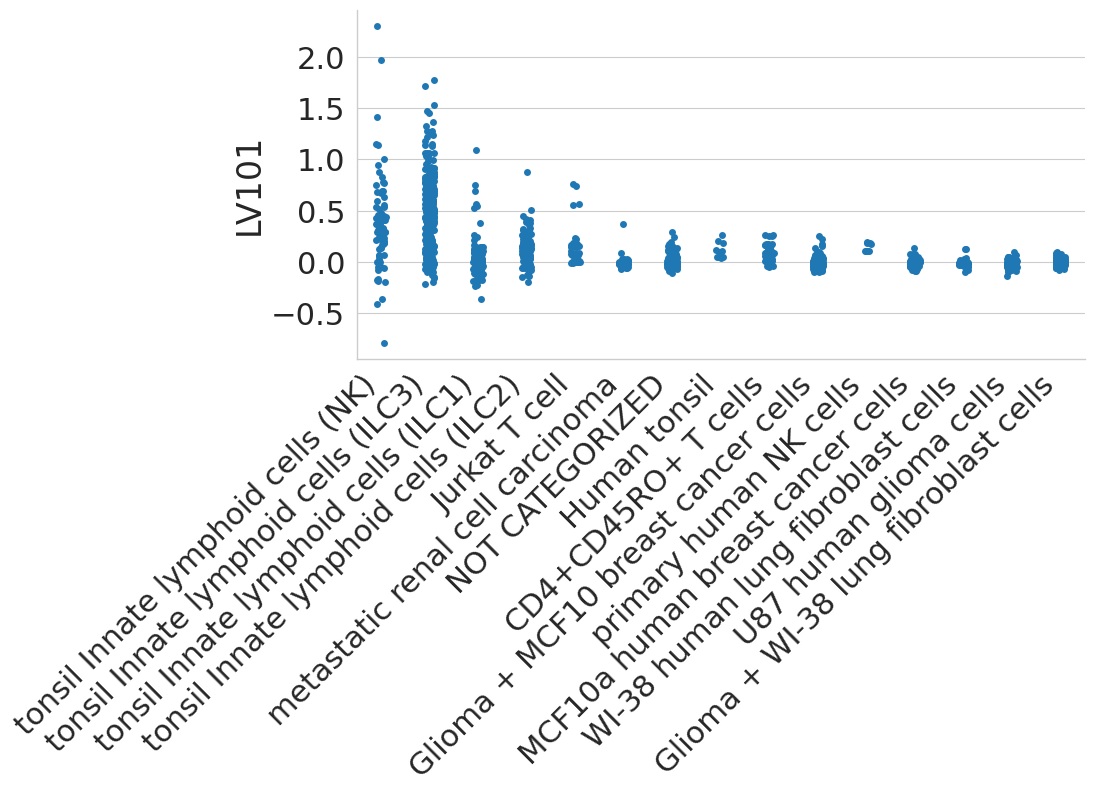

In [41]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    # plt.savefig(
    #     OUTPUT_CELL_TYPE_FILEPATH,
    #     bbox_inches="tight",
    #     facecolor="white",
    # )

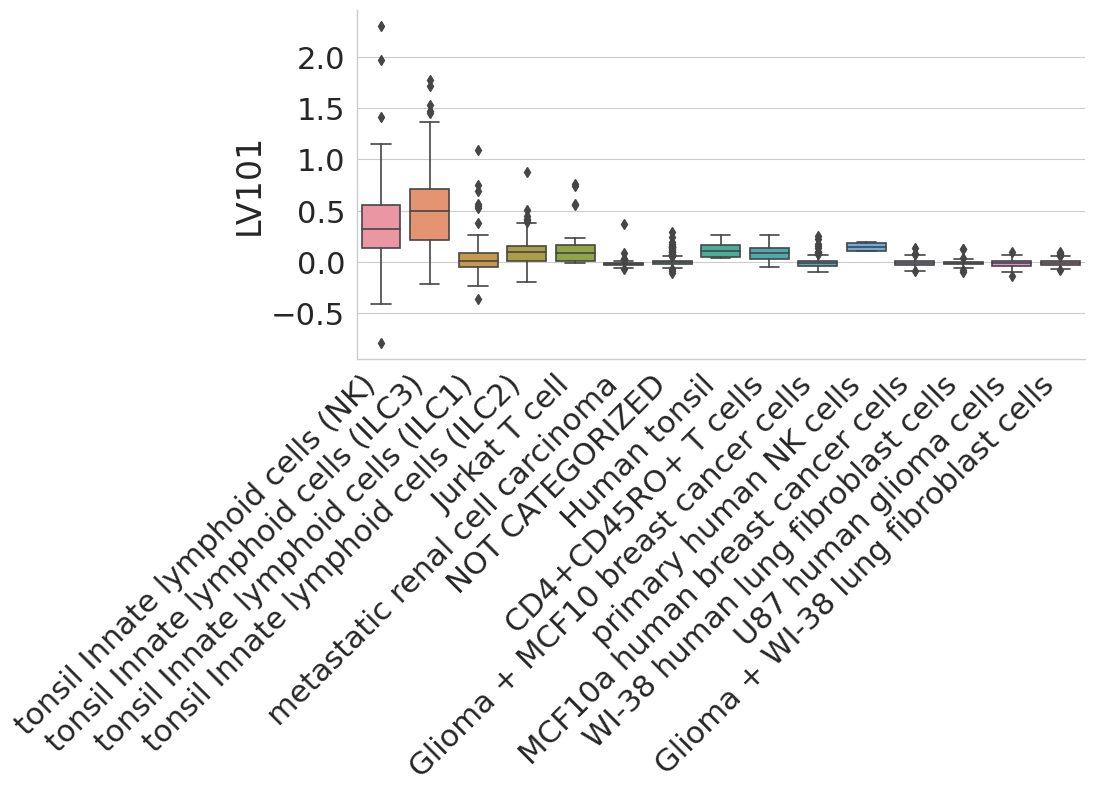

In [42]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="box",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    # plt.savefig(
    #     OUTPUT_CELL_TYPE_FILEPATH,
    #     bbox_inches="tight",
    #     facecolor="white",
    # )

# Debug

In [43]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("mixture of U87")]
#     display(_tmp.head(20))

In [44]:
# # what is there in these projects?
# _tmp = lv_data.loc[["SRP060416"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# )

# display(_tmp.head(60))

# Reduced plot

## Data stats

In [45]:
plot_data_stats = final_plot_data.describe()[LV_NAME]
display(plot_data_stats)

count    1843.000000
mean        0.112114
std         0.267424
min        -0.784933
25%        -0.021528
50%         0.005965
75%         0.113395
max         2.303850
Name: LV101, dtype: float64

In [46]:
plot_data_stats_by_cell_type = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .describe()[LV_NAME]
    .sort_values("50%", ascending=False)
)
display(plot_data_stats_by_cell_type)

,count,mean,std,min,25%,50%,75%,max
cell type,,,,,,,,
tonsil Innate lymphoid cells (ILC3),307.0,0.495122,0.352912,-0.212106,0.214847,0.499231,0.710860,1.770592
tonsil Innate lymphoid cells (NK),74.0,0.386232,0.474470,-0.784933,0.140410,0.324417,0.552414,2.303850
primary human NK cells,8.0,0.146746,0.042072,0.105770,0.107213,0.144950,0.184931,0.193654
Human tonsil,10.0,0.118185,0.078148,0.042233,0.050559,0.104903,0.169390,0.268079
tonsil Innate lymphoid cells (ILC2),137.0,0.106932,0.142139,-0.189565,0.015648,0.096399,0.162053,0.877559
Jurkat T cell,36.0,0.148280,0.198310,-0.006912,0.010140,0.085058,0.167024,0.759358
CD4+CD45RO+ T cells,56.0,0.088425,0.074588,-0.044403,0.035463,0.084419,0.138238,0.262482
tonsil Innate lymphoid cells (ILC1),127.0,0.040064,0.185142,-0.359271,-0.048740,0.015237,0.088226,1.088849
primary human neutrophils,8.0,0.008481,0.008372,-0.003651,0.003944,0.007153,0.011371,0.021809


In [47]:
# keep cell types whose median is larger than the global median
selected_cell_types = plot_data_stats_by_cell_type[
    (plot_data_stats_by_cell_type["50%"] > max(plot_data_stats.loc["50%"], 0.0))
].index
display(selected_cell_types)

Index(['tonsil Innate lymphoid cells (ILC3)',
       'tonsil Innate lymphoid cells (NK)', 'primary human NK cells',
       'Human tonsil', 'tonsil Innate lymphoid cells (ILC2)', 'Jurkat T cell',
       'CD4+CD45RO+ T cells', 'tonsil Innate lymphoid cells (ILC1)',
       'primary human neutrophils'],
      dtype='object', name='cell type')

In [48]:
final_plot_data.shape

(1843, 2)

In [49]:
reduced_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE].isin(selected_cell_types)
]

In [50]:
reduced_plot_data.shape

(763, 2)

## Shorten context names

In [51]:
reduced_plot_data = reduced_plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "tonsil Innate lymphoid cells (ILC3)": "tonsil ILCs (ILC3)",
            "tonsil Innate lymphoid cells (NK)": "tonsil ILCs (NK)",
            "tonsil Innate lymphoid cells (ILC2)": "tonsil ILCs (ILC2)",
            "tonsil Innate lymphoid cells (ILC1)": "tonsil ILCs (ILC1)",
            "primary human NK cells": "NK cells",
            "primary human neutrophils": "Neutrophils",
        }
    }
)

## Set x-axis order

In [52]:
attr_order = (
    reduced_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:8]
    .tolist()
)

In [53]:
len(attr_order)

8

In [54]:
attr_order

['tonsil ILCs (NK)',
 'tonsil ILCs (ILC3)',
 'tonsil ILCs (ILC1)',
 'tonsil ILCs (ILC2)',
 'Jurkat T cell',
 'Human tonsil',
 'CD4+CD45RO+ T cells',
 'NK cells']

## Plot

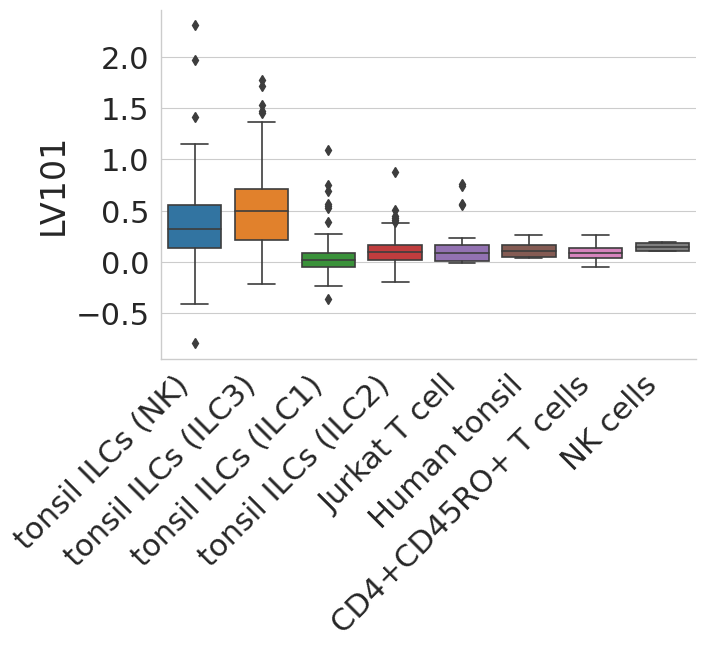

In [55]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=reduced_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="box",
        height=5,
        aspect=1.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )